In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [ ]:
import sys
import h5py
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from itertools import combinations
from glob import glob
from torch.utils.data import Dataset, DataLoader

In [ ]:
sys.path.append("/local/storage/ly349/projects/Deconvolution/Notebooks/")
from utils import get_bioqueue_job_folder, get_bioqueue_file

## Simulation

In [ ]:
def agg_func(job_dict):
    eval_res = []
    for k, v in job_dict.items():
        for cond_idx, (matched_eval_file, unmatched_eval_file) in enumerate(v):
            m_res_df = pd.read_csv(matched_eval_file)
            assert all([c in m_res_df.columns for c in ("Transform", "Model", "CCC")]), matched_eval_file
            m_agg_res_df = m_res_df.loc[
                m_res_df["Transform"]=="log", 
                ["Model", "CCC"]
            ].groupby("Model").agg("median")
            
            um_res_df = pd.read_csv(unmatched_eval_file)
            assert all([c in m_res_df.columns for c in ("Transform", "Model", "CCC")]), unmatched_eval_file
            um_agg_res_df = um_res_df.loc[
                um_res_df["Transform"]=="log", 
                ["Model", "CCC"]
            ].groupby("Model").agg("median")
    
            cond_df = m_agg_res_df.join(um_agg_res_df, lsuffix="_matched", rsuffix="_unmatched").reset_index()
            cond_df["Dataset"] = k
            cond_df["Condition"] = cond_idx
            eval_res.append(cond_df)
    return pd.concat(eval_res)

### Initiation

In [5]:
init_eval_jobs = {
    "5D1": (
        (
            get_bioqueue_file("{{History:20198-v0.2.0-5D1-PROcap-eval.csc.csv.gz}}"),
            get_bioqueue_file("{{History:17124-v0.1.0-5D1-4k-unpaired-61111-eval.csc.csv.gz}}"),
        ),
        (
            get_bioqueue_file("{{History:13968-v0.1.0-5D1_61111-PROcap-eval.csc.csv.gz}}"),
            get_bioqueue_file("{{History:17125-v0.1.0-5D1-4k-unpaired-61111r-eval.csc.csv.gz}}"),
        )
    ),
    "5D2": (
        (
            get_bioqueue_file("{{History:20199-v0.2.0-5D2-PROcap-eval.csc.csv.gz}}"),
            get_bioqueue_file("{{History:17126-v0.1.0-5D2-4k-unpaired-61111-eval.csc.csv.gz}}"),
        ),
        (
            get_bioqueue_file("{{History:13969-v0.1.0-5D2_61111-PROcap-eval.csc.csv.gz}}"),
            get_bioqueue_file("{{History:17127-v0.1.0-5D2-4k-unpaired-61111r-eval.csc.csv.gz}}"),
        )
    ),
}

In [6]:
pr_eval_jobs = {
    "5D3": (
        (
            get_bioqueue_file("{{History:25136-v0.2.0-5D3-ACHLM-quasiPROseq-eval.csc.csv.gz}}"),
            get_bioqueue_file("{{History:17119-v0.1.0-quasiPROseq-5D3-4k-unpaired-61111-eval.csc.csv.gz}}"),
        ),
        (
            get_bioqueue_file("{{History:17090-v0.1.0-5D3_61111-ACHLM-quasiPROseq-eval.csc.csv.gz}}"),
            get_bioqueue_file("{{History:17120-v0.1.0-quasiPROseq-5D3-4k-unpaired-61111r-eval.csc.csv.gz}}"),
        )
    ),
    "5D4": (
        (
            get_bioqueue_file("{{History:25137-v0.2.0-5D4-ACHHL-quasiPROseq-eval.csc.csv.gz}}"),
            get_bioqueue_file("{{History:17121-v0.1.0-quasiPROseq-5D4-4k-unpaired-61111-eval.csc.csv.gz}}"),
        ),
        (
            get_bioqueue_file("{{History:17091-v0.1.0-5D4_61111-ACHHL-quasiPROseq-eval.csc.csv.gz}}"),
            get_bioqueue_file("{{History:17122-v0.1.0-quasiPROseq-5D4-4k-unpaired-61111r-eval.csc.csv.gz}}"),
        )
    ),
}

In [7]:
hist_eval_jobs = {
    "CCHHM_K4me3": (
        (
            get_bioqueue_file("{{History:15606-v0.1.0-5D_CCHHM-H3K4me3-fullCov-all-eval.csc.csv.gz}}"),
            get_bioqueue_file("{{History:17146-v0.1.0-CCHHM-H3K4me3-4k-unpaired-61111-all-eval.csc.csv.gz}}"), 
        ),
        (
            get_bioqueue_file("{{History:17155-v0.1.0-CCHHM_61111-H3K4me3_HQ-all-eval.csc.csv.gz}}"),
            get_bioqueue_file("{{History:17151-v0.1.0-CCHHM-H3K4me3-4k-unpaired-61111r-all-eval.csc.csv.gz}}"),  # update and rerun
        )
    ),
    "KGHHH_K27ac": (
        (
            get_bioqueue_file("{{History:15277-v0.1.0-5D_KGHHH-H3K27ac-fullCov-all-eval.csc.csv.gz}}"),
            get_bioqueue_file("{{History:17150-v0.1.0-KGHHH-H3K27ac-4k-unpaired-61111-all-eval.csc.csv.gz}}"),  # update and rerun
        ),
        (
            get_bioqueue_file("{{History:17149-v0.1.0-KGHHH_61111-H3K27ac_HQ-all-eval.csc.csv.gz}}"),
            get_bioqueue_file("{{History:17152-v0.1.0-KGHHH-H3K27ac-4k-unpaired-61111r-all-eval.csc.csv.gz}}"), 
        ),
    ),
}

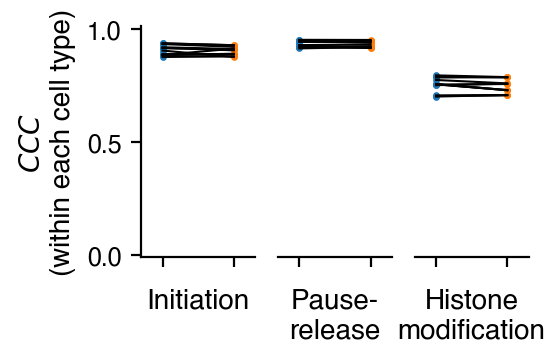

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(2.5, 1.5), sharex=True, sharey=True)
deltas = []
ax = axs[0]
sub_df = agg_func(init_eval_jobs)[["CCC_matched", "CCC_unmatched"]].copy().reset_index(drop=True)
ind = np.arange(sub_df.shape[1])
for i in sub_df.columns:
    ax.scatter(np.repeat(i, len(sub_df[i])), sub_df[i], s=2)

delta = np.zeros(sub_df.shape[0])
for nr, row in sub_df.iterrows():
    for index, c in enumerate(sub_df.columns):
        if index == 0:
            continue
        prev = sub_df.columns[index - 1]
        ax.plot(
            (prev, c), (row[prev], row[c]), 
            linewidth=0.75, color="black"
        )
        delta[nr] = row[prev] - row[c]
deltas.append(delta)
plt.xticks(ind, ["", ""])
ax.set_xlabel("Initiation")

ax = axs[1]
sub_df = agg_func(pr_eval_jobs)[["CCC_matched", "CCC_unmatched"]].copy().reset_index(drop=True)
sub_df.columns = [0, 1]
ind = np.arange(2)
for i in sub_df.columns:
    ax.scatter(np.repeat(i, len(sub_df[i])), sub_df[i], s=2)
delta = np.zeros(sub_df.shape[0])
for nr, row in sub_df.iterrows():
    for index, c in enumerate(sub_df.columns):
        if index == 0:
            continue
        prev = sub_df.columns[index - 1]
        ax.plot(
            (prev, c), (row[prev], row[c]), 
            linewidth=0.75, color="black"
        )
        delta[nr] = row[prev] - row[c]
deltas.append(delta)
plt.xticks(ind, ["", ""])
ax.set_xlabel("Pause-\nrelease")

ax = axs[2]
sub_df = agg_func(hist_eval_jobs)[["CCC_matched", "CCC_unmatched"]].copy().reset_index(drop=True)
ind = np.arange(sub_df.shape[1])
for i in sub_df.columns:
    ax.scatter(np.repeat(i, len(sub_df[i])), sub_df[i], s=2)
delta = np.zeros(sub_df.shape[0])
for nr, row in sub_df.iterrows():
    for index, c in enumerate(sub_df.columns):
        if index == 0:
            continue
        prev = sub_df.columns[index - 1]
        ax.plot(
            (prev, c), (row[prev], row[c]), 
            linewidth=0.75, color="black"
        )
        delta[nr] = row[prev] - row[c]
deltas.append(delta)
plt.xticks(ind, ["", ""])
ax.set_xlabel("Histone\nmodification")

for i, ax in enumerate(axs):
    ax.set_xlim((-0.3, 1.3))
    ax.set_ylim((-0.01, 1.01))
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    if i > 0:
        ax.spines["left"].set_visible(False)
        ax.tick_params(axis="y", left=False)
    else:
        ax.set_ylabel(r"$CCC$"+"\n(within each cell type)")

In [10]:
abs_deltas = np.abs(np.stack(deltas).flatten())
min(abs_deltas), max(abs_deltas)

(0.0003082577605992842, 0.028499457956571494)

In [11]:
init_rank_eval_jobs = {
    "5D1": (
        (
            get_bioqueue_file("{{History:20198-v0.2.0-5D1-PROcap-eval.crc.csv.gz}}"),
            get_bioqueue_file("{{History:17124-v0.1.0-5D1-4k-unpaired-61111-eval.crc.csv.gz}}"),
        ),
        (
            get_bioqueue_file("{{History:13968-v0.1.0-5D1_61111-PROcap-eval.crc.csv.gz}}"),
            get_bioqueue_file("{{History:17125-v0.1.0-5D1-4k-unpaired-61111r-eval.crc.csv.gz}}"),
        )
    ),
    "5D2": (
        (
            get_bioqueue_file("{{History:20199-v0.2.0-5D2-PROcap-eval.crc.csv.gz}}"),
            get_bioqueue_file("{{History:17126-v0.1.0-5D2-4k-unpaired-61111-eval.crc.csv.gz}}"),
        ),
        (
            get_bioqueue_file("{{History:13969-v0.1.0-5D2_61111-PROcap-eval.crc.csv.gz}}"),
            get_bioqueue_file("{{History:17127-v0.1.0-5D2-4k-unpaired-61111r-eval.crc.csv.gz}}"),
        )
    ),
}

In [12]:
pr_rank_eval_jobs = {
    "5D3": (
        (
            get_bioqueue_file("{{History:25136-v0.2.0-5D3-ACHLM-quasiPROseq-eval.crc.csv.gz}}"),
            get_bioqueue_file("{{History:17119-v0.1.0-quasiPROseq-5D3-4k-unpaired-61111-eval.crc.csv.gz}}"),
        ),
        (
            get_bioqueue_file("{{History:17090-v0.1.0-5D3_61111-ACHLM-quasiPROseq-eval.crc.csv.gz}}"),
            get_bioqueue_file("{{History:17120-v0.1.0-quasiPROseq-5D3-4k-unpaired-61111r-eval.crc.csv.gz}}"),
        )
    ),
    "5D4": (
        (
            get_bioqueue_file("{{History:25137-v0.2.0-5D4-ACHHL-quasiPROseq-eval.crc.csv.gz}}"),
            get_bioqueue_file("{{History:17121-v0.1.0-quasiPROseq-5D4-4k-unpaired-61111-eval.crc.csv.gz}}"),
        ),
        (
            get_bioqueue_file("{{History:17091-v0.1.0-5D4_61111-ACHHL-quasiPROseq-eval.crc.csv.gz}}"),
            get_bioqueue_file("{{History:17122-v0.1.0-quasiPROseq-5D4-4k-unpaired-61111r-eval.crc.csv.gz}}"),
        )
    ),
}

In [13]:
hist_rank_eval_jobs = {
    "CCHHM_K4me3": (
        (
            get_bioqueue_file("{{History:15606-v0.1.0-5D_CCHHM-H3K4me3-fullCov-all-eval.crc.csv.gz}}"),
            get_bioqueue_file("{{History:17146-v0.1.0-CCHHM-H3K4me3-4k-unpaired-61111-all-eval.crc.csv.gz}}"), 
        ),
        (
            get_bioqueue_file("{{History:17155-v0.1.0-CCHHM_61111-H3K4me3_HQ-all-eval.crc.csv.gz}}"),
            get_bioqueue_file("{{History:17151-v0.1.0-CCHHM-H3K4me3-4k-unpaired-61111r-all-eval.crc.csv.gz}}"), 
        )
    ),
    "KGHHH_K27ac": (
        (
            get_bioqueue_file("{{History:15277-v0.1.0-5D_KGHHH-H3K27ac-fullCov-all-eval.crc.csv.gz}}"),
            get_bioqueue_file("{{History:17150-v0.1.0-KGHHH-H3K27ac-4k-unpaired-61111-all-eval.crc.csv.gz}}"), 
        ),
        (
            get_bioqueue_file("{{History:17149-v0.1.0-KGHHH_61111-H3K27ac_HQ-all-eval.crc.csv.gz}}"),
            get_bioqueue_file("{{History:17152-v0.1.0-KGHHH-H3K27ac-4k-unpaired-61111r-all-eval.crc.csv.gz}}"), 
        ),
    ),
}

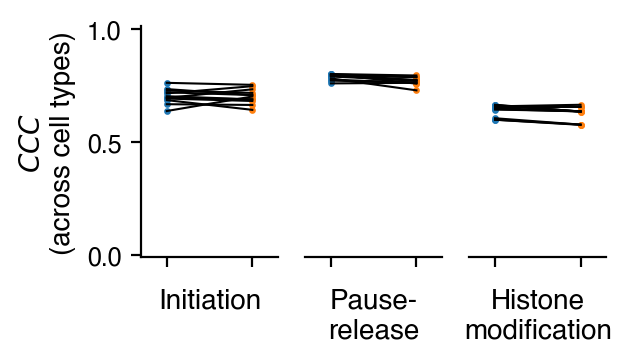

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(3., 1.5), sharex=True, sharey=True)
deltas = []
ax = axs[0]
sub_df = agg_func(init_rank_eval_jobs)[["CCC_matched", "CCC_unmatched"]].copy().reset_index(drop=True)
delta = np.zeros(sub_df.shape[0])
ind = np.arange(sub_df.shape[1])
for i in sub_df.columns:
    ax.scatter(np.repeat(i, len(sub_df[i])), sub_df[i], s=2)
for nr, row in sub_df.iterrows():
    for index, c in enumerate(sub_df.columns):
        if index == 0:
            continue
        prev = sub_df.columns[index - 1]
        ax.plot(
            (prev, c), (row[prev], row[c]), 
            linewidth=0.75, color="black"
        )
        delta[nr] = row[prev] - row[c]
deltas.append(delta)
plt.xticks(ind, ["", ""])
ax.set_xlabel("Initiation")

ax = axs[1]
sub_df = agg_func(pr_rank_eval_jobs)[["CCC_matched", "CCC_unmatched"]].copy().reset_index(drop=True)
delta = np.zeros(sub_df.shape[0])
sub_df.columns = [0, 1]
ind = np.arange(2)
for i in sub_df.columns:
    ax.scatter(np.repeat(i, len(sub_df[i])), sub_df[i], s=2)
for nr, row in sub_df.iterrows():
    for index, c in enumerate(sub_df.columns):
        if index == 0:
            continue
        prev = sub_df.columns[index - 1]
        ax.plot(
            (prev, c), (row[prev], row[c]), 
            linewidth=0.75, color="black"
        )
        delta[nr] = row[prev] - row[c]
deltas.append(delta)
plt.xticks(ind, ["", ""])
ax.set_xlabel("Pause-\nrelease")

ax = axs[2]
sub_df = agg_func(hist_rank_eval_jobs)[["CCC_matched", "CCC_unmatched"]].copy().reset_index(drop=True)
delta = np.zeros(sub_df.shape[0])
ind = np.arange(sub_df.shape[1])
for i in sub_df.columns:
    ax.scatter(np.repeat(i, len(sub_df[i])), sub_df[i], s=2)
for nr, row in sub_df.iterrows():
    for index, c in enumerate(sub_df.columns):
        if index == 0:
            continue
        prev = sub_df.columns[index - 1]
        ax.plot(
            (prev, c), (row[prev], row[c]), 
            linewidth=0.75, color="black"
        )
        delta[nr] = row[prev] - row[c]
deltas.append(delta)
plt.xticks(ind, ["", ""])
ax.set_xlabel("Histone\nmodification")

for i, ax in enumerate(axs):
    ax.set_xlim((-0.3, 1.3))
    ax.set_ylim((-0.01, 1.01))
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    if i > 0:
        ax.spines["left"].set_visible(False)
        ax.tick_params(axis="y", left=False)
    else:
        ax.set_ylabel(r"$CCC$"+"\n(across cell types)")

In [16]:
abs_deltas = np.abs(np.stack(deltas).flatten())
min(abs_deltas), max(abs_deltas)

(0.001294245201816313, 0.06409158111126378)

## Real case

### Liver PRO-cap

In [ ]:
class EvaluationDataset(Dataset):
    def __init__(self, preds, cluster_labels=[]):
        """

        Parameters
        ----------
        pl_pred_bw_file : 
        """
        n_regions = [p.shape[1] for p in preds]
        assert len(set(n_regions)) == 1
        self.n_regions = n_regions[0]
        self.data = preds
        self._cluster_labels = cluster_labels

    def __len__(self):
        return self.n_regions

    @property
    def cluster_labels(self):
        if len(self._cluster_labels) > 0:
            labels = []
            for i in range(1, len(self.data)+1):
                labels.extend(list([f"{c}_{i}" for c in self._cluster_labels]))
            return labels
        else:
            return []

    def __getitem__(self, idx: int):
        return list([torch.from_numpy(self.data[i][:, idx]) for i in range(len(self.data))])

In [ ]:
def evaluate_corr(evaluation_datasets):
    n_batches = 0
    n_clusters = len(evaluation_datasets.cluster_labels)
    results = torch.zeros(n_clusters, n_clusters)
    _iter = DataLoader(evaluation_datasets, batch_size=32, shuffle=True, num_workers=1)
    
    for ds in _iter:
        n_batches += 1
        stacked_ds = torch.hstack(ds).T
        results += stacked_ds.corrcoef()
    print(ds[0].shape, torch.hstack(ds).shape, torch.hstack(ds).T.shape)
    return results / n_batches

In [ ]:
liver_dec_jobs = {
    "18338": "donor 1",
    "20284": "donor 2",
}
liver_dec_job_files = {k: glob(f"{get_bioqueue_job_folder(k)}/log_r1/*.predictions.h5")[0] for k in liver_dec_jobs.keys()}
liver_dec_job_handles = {k: h5py.File(liver_dec_job_files[k], "r") for k in liver_dec_job_files.keys()}
per_job_regions = {k: h["regions"] for k, h in liver_dec_job_handles.items()}
# sanity check
for i, j in combinations(liver_dec_job_handles.keys(), 2):
    assert np.allclose(per_job_regions[i][:, 1] == 1, per_job_regions[j][:, 1] == 1)
# extract cluster names
cluster_names = {k: h["preds"].attrs["cluster_names"].tolist() for k, h in liver_dec_job_handles.items()}
_lists = list(cluster_names.values())
assert all(lst == _lists[0] for lst in _lists)
# get counts prediction
per_job_counts_pred = {k: np.nansum(np.abs(h["preds"][:]), -1).sum(-1) for k, h in liver_dec_job_handles.items()}
for h in liver_dec_job_handles.values(): h.close()

In [ ]:
_lists

In [ ]:
ds = EvaluationDataset(
    (
        per_job_counts_pred["18338"], 
        per_job_counts_pred["20284"], 
    ),
    cluster_labels=_lists[0]
)
cor_mat = evaluate_corr(ds)
cor_df = pd.DataFrame(cor_mat, columns=ds.cluster_labels, index=ds.cluster_labels).sort_index(axis=1, ascending=False).sort_index(axis=0, ascending=False)
cor_df.head()

In [ ]:
cor_df = pd.DataFrame(cor_mat, columns=ds.cluster_labels, index=ds.cluster_labels).sort_index(axis=1, ascending=False).sort_index(axis=0, ascending=False)
cor_df.head()

In [ ]:
donor_color_map = {"paired": "#06d6a0", "unpaired": "#ef476f"}
g = sns.clustermap(
    cor_df, method="single",
    cmap="Blues", figsize=(2.5, 2.5), 
    col_colors=[donor_color_map["paired"] if c.find("_1") != -1 else donor_color_map["unpaired"] for c in cor_df.index], 
    dendrogram_ratio=0.01,
    cbar_pos=(0.55, 0.59, 0.05, 0.25)
)

# define the rectangles to highlight, (x, y, width, height)
rectangles = [
    (0, 0, 2, 2),
    (2, 2, 2, 2),
    (4, 4, 2, 2),
    (6, 6, 2, 2),
    (8, 8, 2, 2),
]

# add rectangles to the heatmap
for rect in rectangles:
    x, y, width, height = rect
    rect_patch = patches.Rectangle(
        (x, y),  # Bottom-left corner in data coordinates
        width,               # Width of the rectangle
        height,              # Height of the rectangle
        linewidth=1.,         # Line width of the rectangle border
        edgecolor='gray',     # Color of the rectangle border
        facecolor='none',    # Rectangle fill color (none for transparent fill)
        linestyle='--'       # Line style
    )
    g.ax_heatmap.add_patch(rect_patch)

g.ax_heatmap.set_xticks([1,3,5,7], ["hepatocyte", "macrophage", "fibroblast", "endothelial cell"], rotation=45, ha="right")
g.ax_heatmap.set_yticks([])
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)

# donor annotation
handles = [patches.Patch(facecolor=donor_color_map[name]) for name in donor_color_map]
plt.legend(handles, ["matched", "unmatched"], title="", frameon=False, 
           bbox_to_anchor=(0.32, 0.93), 
           bbox_transform=plt.gcf().transFigure, 
           loc="lower center", ncol=3)